<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/09_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

## 9.1 Working with Sequences

### 9.1.3 Training

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
class Data(d2l.DataModule):
  def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
    self.save_hyperparameters()
    self.time = torch.arange(1, T + 1, dtype=torch.float32)      # T = 1, 0000, 1000
    self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2  # x = sin(0.01T) + N(0, 1) * 0.2

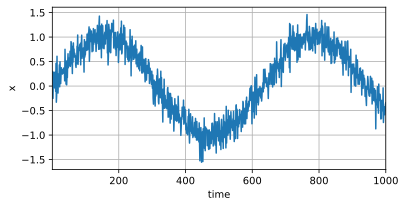

In [ ]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
  features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
  self.features = torch.stack(features, 1)
  self.labels = self.x[self.tau:].reshape((-1, 1))
  i = slice(0, self.num_train) if train else slice(self.num_train, None)
  return self.get_tensorloader([self.features, self.labels], train, i)


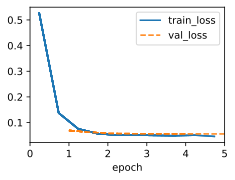

In [ ]:
model = d2l.LinearRegression(lr=0.01)
data = Data()
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

### 9.1.4 Prediction

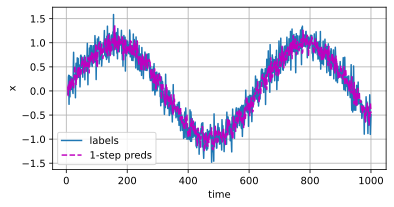

In [ ]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

In [ ]:
multistep_preds = torch.zeros(data.T)
multistep_preds [:] = data.x

for i in range(data.num_train + data.tau, data.T):
  multistep_preds[i] = model(multistep_preds[i - data.tau:i].reshape((1, -1)))

multistep_preds = multistep_preds.detach().numpy()

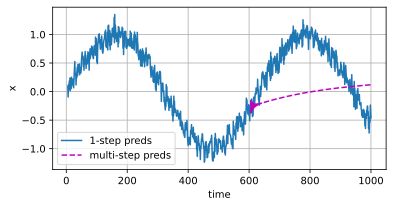

In [ ]:
d2l.plot([data.time[data.tau:], data.time[data.num_train + data.tau:]],
         [onestep_preds, multistep_preds[data.num_train + data.tau:]],
         'time', 'x', legend=['1-step preds', 'multi-step preds'], figsize=(6, 3))

In [ ]:
def k_step_pred(k):
  features = []
  for i in range(data.tau):
    features.append(data.x[i: i+data.T - data.tau-k+1])

  for i in range(k):
    preds = model(torch.stack(features[i : i+data.tau], 1))
    features.append(preds.reshape(-1))

  return features[data.tau:]

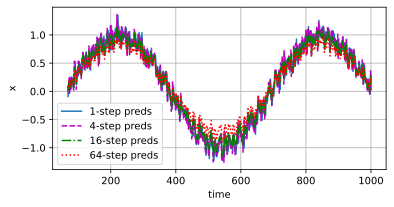

In [ ]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])

d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k-1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

## 9.2 Converting Raw Text into Sequence Data

In [31]:
import collections
import random
import re
import torch
from d2l import torch as d2l

### 9.2.1 Reading the Dataset

In [32]:
class TimeMachine(d2l.DataModule):
  def _download(self):
    fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                         '090b5e7e70c295757f55df93cb0a180b9691891a')
    with open(fname) as f:
      return f.read()

In [33]:
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [34]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
  return re.sub('[^A-Za-z]+', ' ', text).lower()

In [35]:
text = data._preprocess(raw_text)
text[0:60]

'the time machine by h g wells i the time traveller for so it'

### 9.2.2 Tokenization

In [36]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
  return list(text)

In [37]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

### 9.2.3 Vocabulary

In [38]:
class Vocab:
  def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
    # Flatten a 2D list if needed.
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    
    # Count token frequencies
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                              reverse=True)
    
    # The list of unique tokens
    self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
        token for token, freq in self.token_freqs if freq >= min_freq])))
    self.token_to_idx = {token: idx
                         for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']

In [41]:
vocab = Vocab()
indices = vocab[tokens[:100]]
print('indices: ', indices)
print('words: ', vocab.to_tokens(indices))

indices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
words:  ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk